In [1]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.config.list_physical_devices(device_type=None)

import tensorflow.keras
from tensorflow.keras import models
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import h5py
from sklearn.utils import shuffle

from keras.models import Sequential
from keras.layers import Bidirectional, GlobalMaxPool1D

from keras import callbacks 
from keras.constraints import maxnorm
import keras
from sklearn.model_selection import KFold

In [2]:
#retrieve data
num = 4000 # number of profiles
nvza = 12 # number of channels
nsza=6



In [3]:
# spatial slicing dimensions
s = 82 # output slice size
ts = 82 # input slice size 32


In [12]:
#get the averaged reflectance from the dataset 
r=np.load('all_angles_r.npy')
c=np.load('cot_500m.npy')


In [13]:
print(r.shape)
r=r.reshape((4000,82,72))
print(r.shape)
print(c.shape)

(4000, 82, 6, 12)
(4000, 82, 72)
(4000, 82)


In [14]:
r,c= shuffle(r, c, random_state=0)#Shuffle arrays in a consistent way.

#train test split
trp = 0.8; # 80 percent to train, includes validation
train_size=int(trp*num)
test_size = num - train_size #20% for testing:0.20*4000=800

print("train_size:",train_size,'profiles')
print("test_size:",test_size,'profiles')


train_size: 3200 profiles
test_size: 800 profiles


In [15]:
keras.utils.plot_model(model, show_shapes=True,show_layer_names=True,expand_nested=True,rankdir='TB')

NameError: name 'model' is not defined

In [16]:
import os
checkpoint_path = "training_all_bilstmembedding/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

In [20]:
#Bi-LSTM model-------------------------------------------------------------------------------------------------



ltype = 'mean_squared_error'
type2=tf.keras.metrics.RootMeanSquaredError()
bsize = 16
eps = 2000



def eval_model(train_image, test_image, train_label, test_label):
    input_layer = tf.keras.layers.Input(shape=(ts,72),name='Input')
    #patch embedding layer
    #The PatchEncoder layer will linearly transform a patch by projecting it into a vector of size projection_dim
    projection=tf.keras.layers.Dense(64,activation='relu')(input_layer)
    positions = tf.range(start=0, limit=82, delta=1)
    embedding=tf.keras.layers.Embedding(input_dim=(82),output_dim=(64),input_length=128)(positions)
        # adds a learnable position embedding to the projected vector
    encoded = projection+embedding

    bi=Bidirectional(tf.keras.layers.LSTM(units=64, activation='tanh',return_sequences = True))(encoded)
    bi=Bidirectional(tf.keras.layers.LSTM(units=64, activation='tanh',return_sequences = True))(bi)
    
    flat=tf.keras.layers.Flatten()(bi)

    output=tf.keras.layers.Dense(82, activation="linear")(flat)

    model = tf.keras.models.Model(inputs=input_layer, outputs=output)

    model.compile(optimizer='adam',loss='mse',metrics=[ltype,type2])
    
    model.summary()

    #earlystopping to find the optimal number of epochs 
    earlystopping = callbacks.EarlyStopping(monitor ="val_loss",  
                                                mode ="min", patience = 25,  
                                                restore_best_weights = True,
                                               verbose=1) 
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

    history = model.fit(train_image,train_label,batch_size = bsize,epochs = eps,validation_split=0.25,
                              callbacks =[earlystopping,cp_callback])#validation set(15%)/trainset(85%)=0.17647

    # test and predict ---------------------------------------------------------------------------------------

    print('test result')
    results = model.evaluate(test_image, test_label)
    predictions=model.predict(test_image)

    mse = results[1]
    rmse = results[2]

    return model,rmse,mse,history,predictions

In [21]:
n_folds=5

kf = KFold(n_splits=n_folds,random_state=None, shuffle=False)
print(kf.get_n_splits(r))
print(kf)
ratio=int(r.shape[0]/n_folds)

X_train=np.zeros((5,800*4,82,72))
y_train=np.zeros((5,ratio*(n_folds-1),82))
X_test=np.zeros((n_folds,ratio,82,72))
y_test=np.zeros((n_folds,ratio,82))

count=0
for train_index, test_index in kf.split(r):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train[count], X_test[count] = r[train_index], r[test_index]
    y_train[count], y_test[count] = c[train_index], c[test_index]
    count+=1

5
KFold(n_splits=5, random_state=None, shuffle=False)
TRAIN: [ 800  801  802 ... 3997 3998 3999] TEST: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 

TRAIN: [   0    1    2 ... 3997 3998 3999] TEST: [2400 2401 2402 2403 2404 2405 2406 2407 2408 2409 2410 2411 2412 2413
 2414 2415 2416 2417 2418 2419 2420 2421 2422 2423 2424 2425 2426 2427
 2428 2429 2430 2431 2432 2433 2434 2435 2436 2437 2438 2439 2440 2441
 2442 2443 2444 2445 2446 2447 2448 2449 2450 2451 2452 2453 2454 2455
 2456 2457 2458 2459 2460 2461 2462 2463 2464 2465 2466 2467 2468 2469
 2470 2471 2472 2473 2474 2475 2476 2477 2478 2479 2480 2481 2482 2483
 2484 2485 2486 2487 2488 2489 2490 2491 2492 2493 2494 2495 2496 2497
 2498 2499 2500 2501 2502 2503 2504 2505 2506 2507 2508 2509 2510 2511
 2512 2513 2514 2515 2516 2517 2518 2519 2520 2521 2522 2523 2524 2525
 2526 2527 2528 2529 2530 2531 2532 2533 2534 2535 2536 2537 2538 2539
 2540 2541 2542 2543 2544 2545 2546 2547 2548 2549 2550 2551 2552 2553
 2554 2555 2556 2557 2558 2559 2560 2561 2562 2563 2564 2565 2566 2567
 2568 2569 2570 2571 2572 2573 2574 2575 2576 2577 2578 2579 2580 2581
 2582 2583 2584 2585 2586 25

In [22]:
# evaluate model----------------------------------------------------------------------------------------------
cv_scores = list()
cv_scores2 = list()

for n in range(n_folds):
        # split data    
    train_image, test_image, train_label, test_label = X_train[n],X_test[n],y_train[n],y_test[n]
        # evaluate model
    model,rmse,mse,history,predictions= eval_model(train_image, test_image, train_label, test_label)
    print('MSE on test set in fold'+str(n+1)+' : '+str(mse))
    print('RMSE on test set in fold'+str(n+1)+' : '+str(rmse))

    cv_scores.append(mse)
    cv_scores2.append(rmse)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 82, 72)]          0         
_________________________________________________________________
dense_2 (Dense)              (None, 82, 64)            4672      
_________________________________________________________________
tf.__operators__.add_1 (TFOp (None, 82, 64)            0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 82, 128)           66048     
_________________________________________________________________
bidirectional_3 (Bidirection (None, 82, 128)           98816     
_________________________________________________________________
flatten_1 (Flatten)          (None, 10496)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 82)                8607


Epoch 00023: saving model to training_all_bilstmembedding\cp.ckpt
Epoch 24/2000
150/150 [==============================] - 3s 19ms/step - loss: 0.1768 - mean_squared_error: 0.1768 - root_mean_squared_error: 0.4204 - val_loss: 0.2067 - val_mean_squared_error: 0.2067 - val_root_mean_squared_error: 0.4546

Epoch 00024: saving model to training_all_bilstmembedding\cp.ckpt
Epoch 25/2000
150/150 [==============================] - 3s 19ms/step - loss: 0.1698 - mean_squared_error: 0.1698 - root_mean_squared_error: 0.4121 - val_loss: 0.1890 - val_mean_squared_error: 0.1890 - val_root_mean_squared_error: 0.4347

Epoch 00025: saving model to training_all_bilstmembedding\cp.ckpt
Epoch 26/2000
150/150 [==============================] - 3s 19ms/step - loss: 0.1746 - mean_squared_error: 0.1746 - root_mean_squared_error: 0.4178 - val_loss: 0.1860 - val_mean_squared_error: 0.1860 - val_root_mean_squared_error: 0.4313

Epoch 00026: saving model to training_all_bilstmembedding\cp.ckpt
Epoch 27/2000
150/


Epoch 00050: saving model to training_all_bilstmembedding\cp.ckpt
Epoch 51/2000
150/150 [==============================] - 3s 20ms/step - loss: 0.0975 - mean_squared_error: 0.0975 - root_mean_squared_error: 0.3119 - val_loss: 0.1215 - val_mean_squared_error: 0.1215 - val_root_mean_squared_error: 0.3485

Epoch 00051: saving model to training_all_bilstmembedding\cp.ckpt
Epoch 52/2000
150/150 [==============================] - 3s 20ms/step - loss: 0.0911 - mean_squared_error: 0.0911 - root_mean_squared_error: 0.3018 - val_loss: 0.1034 - val_mean_squared_error: 0.1034 - val_root_mean_squared_error: 0.3216

Epoch 00052: saving model to training_all_bilstmembedding\cp.ckpt
Epoch 53/2000
150/150 [==============================] - 3s 20ms/step - loss: 0.0818 - mean_squared_error: 0.0818 - root_mean_squared_error: 0.2858 - val_loss: 0.1119 - val_mean_squared_error: 0.1119 - val_root_mean_squared_error: 0.3345

Epoch 00053: saving model to training_all_bilstmembedding\cp.ckpt
Epoch 54/2000
150/


Epoch 00077: saving model to training_all_bilstmembedding\cp.ckpt
Epoch 78/2000
150/150 [==============================] - 3s 19ms/step - loss: 0.0736 - mean_squared_error: 0.0736 - root_mean_squared_error: 0.2713 - val_loss: 0.0862 - val_mean_squared_error: 0.0862 - val_root_mean_squared_error: 0.2937

Epoch 00078: saving model to training_all_bilstmembedding\cp.ckpt
Epoch 79/2000
150/150 [==============================] - 3s 19ms/step - loss: 0.0662 - mean_squared_error: 0.0662 - root_mean_squared_error: 0.2571 - val_loss: 0.0800 - val_mean_squared_error: 0.0800 - val_root_mean_squared_error: 0.2828

Epoch 00079: saving model to training_all_bilstmembedding\cp.ckpt
Epoch 80/2000
150/150 [==============================] - 3s 19ms/step - loss: 0.0549 - mean_squared_error: 0.0549 - root_mean_squared_error: 0.2342 - val_loss: 0.0831 - val_mean_squared_error: 0.0831 - val_root_mean_squared_error: 0.2882

Epoch 00080: saving model to training_all_bilstmembedding\cp.ckpt
Epoch 81/2000
150/


Epoch 00104: saving model to training_all_bilstmembedding\cp.ckpt
Epoch 105/2000
150/150 [==============================] - 3s 19ms/step - loss: 0.0485 - mean_squared_error: 0.0485 - root_mean_squared_error: 0.2202 - val_loss: 0.0606 - val_mean_squared_error: 0.0606 - val_root_mean_squared_error: 0.2462

Epoch 00105: saving model to training_all_bilstmembedding\cp.ckpt
Epoch 106/2000
150/150 [==============================] - 3s 19ms/step - loss: 0.0451 - mean_squared_error: 0.0451 - root_mean_squared_error: 0.2123 - val_loss: 0.0799 - val_mean_squared_error: 0.0799 - val_root_mean_squared_error: 0.2827

Epoch 00106: saving model to training_all_bilstmembedding\cp.ckpt
Epoch 107/2000
150/150 [==============================] - 3s 19ms/step - loss: 0.0480 - mean_squared_error: 0.0480 - root_mean_squared_error: 0.2191 - val_loss: 0.0673 - val_mean_squared_error: 0.0673 - val_root_mean_squared_error: 0.2594

Epoch 00107: saving model to training_all_bilstmembedding\cp.ckpt
Epoch 108/2000



Epoch 00131: saving model to training_all_bilstmembedding\cp.ckpt
Epoch 132/2000
150/150 [==============================] - 3s 19ms/step - loss: 0.0320 - mean_squared_error: 0.0320 - root_mean_squared_error: 0.1788 - val_loss: 0.0589 - val_mean_squared_error: 0.0589 - val_root_mean_squared_error: 0.2426

Epoch 00132: saving model to training_all_bilstmembedding\cp.ckpt
Epoch 133/2000
150/150 [==============================] - 3s 19ms/step - loss: 0.0354 - mean_squared_error: 0.0354 - root_mean_squared_error: 0.1880 - val_loss: 0.0558 - val_mean_squared_error: 0.0558 - val_root_mean_squared_error: 0.2362

Epoch 00133: saving model to training_all_bilstmembedding\cp.ckpt
Epoch 134/2000
150/150 [==============================] - 3s 19ms/step - loss: 0.0332 - mean_squared_error: 0.0332 - root_mean_squared_error: 0.1821 - val_loss: 0.0548 - val_mean_squared_error: 0.0548 - val_root_mean_squared_error: 0.2340

Epoch 00134: saving model to training_all_bilstmembedding\cp.ckpt
Epoch 135/2000



Epoch 00158: saving model to training_all_bilstmembedding\cp.ckpt
Epoch 159/2000
150/150 [==============================] - 3s 19ms/step - loss: 0.0243 - mean_squared_error: 0.0243 - root_mean_squared_error: 0.1558 - val_loss: 0.0522 - val_mean_squared_error: 0.0522 - val_root_mean_squared_error: 0.2286

Epoch 00159: saving model to training_all_bilstmembedding\cp.ckpt
Epoch 160/2000
150/150 [==============================] - 3s 19ms/step - loss: 0.0289 - mean_squared_error: 0.0289 - root_mean_squared_error: 0.1699 - val_loss: 0.0473 - val_mean_squared_error: 0.0473 - val_root_mean_squared_error: 0.2174

Epoch 00160: saving model to training_all_bilstmembedding\cp.ckpt
Epoch 161/2000
150/150 [==============================] - 3s 19ms/step - loss: 0.0280 - mean_squared_error: 0.0280 - root_mean_squared_error: 0.1672 - val_loss: 0.0541 - val_mean_squared_error: 0.0541 - val_root_mean_squared_error: 0.2326

Epoch 00161: saving model to training_all_bilstmembedding\cp.ckpt
Epoch 162/2000



Epoch 00185: saving model to training_all_bilstmembedding\cp.ckpt
Epoch 186/2000
150/150 [==============================] - 3s 19ms/step - loss: 0.0283 - mean_squared_error: 0.0283 - root_mean_squared_error: 0.1682 - val_loss: 0.0491 - val_mean_squared_error: 0.0491 - val_root_mean_squared_error: 0.2216

Epoch 00186: saving model to training_all_bilstmembedding\cp.ckpt
Epoch 187/2000
150/150 [==============================] - 3s 19ms/step - loss: 0.0198 - mean_squared_error: 0.0198 - root_mean_squared_error: 0.1406 - val_loss: 0.0470 - val_mean_squared_error: 0.0470 - val_root_mean_squared_error: 0.2168

Epoch 00187: saving model to training_all_bilstmembedding\cp.ckpt
Epoch 188/2000
150/150 [==============================] - 3s 19ms/step - loss: 0.0206 - mean_squared_error: 0.0206 - root_mean_squared_error: 0.1431 - val_loss: 0.0554 - val_mean_squared_error: 0.0554 - val_root_mean_squared_error: 0.2354

Epoch 00188: saving model to training_all_bilstmembedding\cp.ckpt
Epoch 189/2000



Epoch 00212: saving model to training_all_bilstmembedding\cp.ckpt
Epoch 213/2000
150/150 [==============================] - 3s 19ms/step - loss: 0.0280 - mean_squared_error: 0.0280 - root_mean_squared_error: 0.1666 - val_loss: 0.0511 - val_mean_squared_error: 0.0511 - val_root_mean_squared_error: 0.2260

Epoch 00213: saving model to training_all_bilstmembedding\cp.ckpt
Epoch 214/2000
150/150 [==============================] - 3s 19ms/step - loss: 0.0176 - mean_squared_error: 0.0176 - root_mean_squared_error: 0.1328 - val_loss: 0.0577 - val_mean_squared_error: 0.0577 - val_root_mean_squared_error: 0.2402

Epoch 00214: saving model to training_all_bilstmembedding\cp.ckpt
Epoch 215/2000
150/150 [==============================] - 3s 19ms/step - loss: 0.0193 - mean_squared_error: 0.0193 - root_mean_squared_error: 0.1388 - val_loss: 0.0480 - val_mean_squared_error: 0.0480 - val_root_mean_squared_error: 0.2191

Epoch 00215: saving model to training_all_bilstmembedding\cp.ckpt
Epoch 216/2000


150/150 [==============================] - 9s 28ms/step - loss: 81.6152 - mean_squared_error: 81.6152 - root_mean_squared_error: 6.1095 - val_loss: 17.1563 - val_mean_squared_error: 17.1563 - val_root_mean_squared_error: 4.1420

Epoch 00001: saving model to training_all_bilstmembedding\cp.ckpt
Epoch 2/2000
150/150 [==============================] - 3s 19ms/step - loss: 13.6930 - mean_squared_error: 13.6930 - root_mean_squared_error: 3.6962 - val_loss: 8.5421 - val_mean_squared_error: 8.5421 - val_root_mean_squared_error: 2.9227

Epoch 00002: saving model to training_all_bilstmembedding\cp.ckpt
Epoch 3/2000
150/150 [==============================] - 3s 19ms/step - loss: 7.1951 - mean_squared_error: 7.1951 - root_mean_squared_error: 2.6804 - val_loss: 5.1348 - val_mean_squared_error: 5.1348 - val_root_mean_squared_error: 2.2660

Epoch 00003: saving model to training_all_bilstmembedding\cp.ckpt
Epoch 4/2000
150/150 [==============================] - 3s 19ms/step - loss: 4.5377 - mean_squa

150/150 [==============================] - 3s 19ms/step - loss: 0.1480 - mean_squared_error: 0.1480 - root_mean_squared_error: 0.3846 - val_loss: 0.1890 - val_mean_squared_error: 0.1890 - val_root_mean_squared_error: 0.4347

Epoch 00028: saving model to training_all_bilstmembedding\cp.ckpt
Epoch 29/2000
150/150 [==============================] - 3s 19ms/step - loss: 0.1331 - mean_squared_error: 0.1331 - root_mean_squared_error: 0.3648 - val_loss: 0.1679 - val_mean_squared_error: 0.1679 - val_root_mean_squared_error: 0.4098

Epoch 00029: saving model to training_all_bilstmembedding\cp.ckpt
Epoch 30/2000
150/150 [==============================] - 3s 19ms/step - loss: 0.1413 - mean_squared_error: 0.1413 - root_mean_squared_error: 0.3758 - val_loss: 0.1604 - val_mean_squared_error: 0.1604 - val_root_mean_squared_error: 0.4005

Epoch 00030: saving model to training_all_bilstmembedding\cp.ckpt
Epoch 31/2000
150/150 [==============================] - 3s 19ms/step - loss: 0.1272 - mean_squared

150/150 [==============================] - 3s 19ms/step - loss: 0.0809 - mean_squared_error: 0.0809 - root_mean_squared_error: 0.2843 - val_loss: 0.0990 - val_mean_squared_error: 0.0990 - val_root_mean_squared_error: 0.3147

Epoch 00055: saving model to training_all_bilstmembedding\cp.ckpt
Epoch 56/2000
150/150 [==============================] - 3s 20ms/step - loss: 0.0792 - mean_squared_error: 0.0792 - root_mean_squared_error: 0.2813 - val_loss: 0.1324 - val_mean_squared_error: 0.1324 - val_root_mean_squared_error: 0.3639

Epoch 00056: saving model to training_all_bilstmembedding\cp.ckpt
Epoch 57/2000
150/150 [==============================] - 3s 19ms/step - loss: 0.0927 - mean_squared_error: 0.0927 - root_mean_squared_error: 0.3043 - val_loss: 0.0932 - val_mean_squared_error: 0.0932 - val_root_mean_squared_error: 0.3052

Epoch 00057: saving model to training_all_bilstmembedding\cp.ckpt
Epoch 58/2000
150/150 [==============================] - 3s 19ms/step - loss: 0.0831 - mean_squared

150/150 [==============================] - 3s 19ms/step - loss: 0.0567 - mean_squared_error: 0.0567 - root_mean_squared_error: 0.2380 - val_loss: 0.0906 - val_mean_squared_error: 0.0906 - val_root_mean_squared_error: 0.3011

Epoch 00082: saving model to training_all_bilstmembedding\cp.ckpt
Epoch 83/2000
150/150 [==============================] - 3s 19ms/step - loss: 0.0752 - mean_squared_error: 0.0752 - root_mean_squared_error: 0.2740 - val_loss: 0.0743 - val_mean_squared_error: 0.0743 - val_root_mean_squared_error: 0.2725

Epoch 00083: saving model to training_all_bilstmembedding\cp.ckpt
Epoch 84/2000
150/150 [==============================] - 3s 19ms/step - loss: 0.0529 - mean_squared_error: 0.0529 - root_mean_squared_error: 0.2300 - val_loss: 0.0645 - val_mean_squared_error: 0.0645 - val_root_mean_squared_error: 0.2539

Epoch 00084: saving model to training_all_bilstmembedding\cp.ckpt
Epoch 85/2000
150/150 [==============================] - 3s 19ms/step - loss: 0.0492 - mean_squared

150/150 [==============================] - 3s 21ms/step - loss: 0.0377 - mean_squared_error: 0.0377 - root_mean_squared_error: 0.1940 - val_loss: 0.0778 - val_mean_squared_error: 0.0778 - val_root_mean_squared_error: 0.2789

Epoch 00109: saving model to training_all_bilstmembedding\cp.ckpt
Epoch 110/2000
150/150 [==============================] - 3s 20ms/step - loss: 0.0558 - mean_squared_error: 0.0558 - root_mean_squared_error: 0.2361 - val_loss: 0.0593 - val_mean_squared_error: 0.0593 - val_root_mean_squared_error: 0.2436

Epoch 00110: saving model to training_all_bilstmembedding\cp.ckpt
Epoch 111/2000
150/150 [==============================] - 3s 21ms/step - loss: 0.0439 - mean_squared_error: 0.0439 - root_mean_squared_error: 0.2094 - val_loss: 0.0689 - val_mean_squared_error: 0.0689 - val_root_mean_squared_error: 0.2624

Epoch 00111: saving model to training_all_bilstmembedding\cp.ckpt
Epoch 112/2000
150/150 [==============================] - 3s 20ms/step - loss: 0.0420 - mean_squa

150/150 [==============================] - 3s 20ms/step - loss: 0.0286 - mean_squared_error: 0.0286 - root_mean_squared_error: 0.1691 - val_loss: 0.0516 - val_mean_squared_error: 0.0516 - val_root_mean_squared_error: 0.2272

Epoch 00136: saving model to training_all_bilstmembedding\cp.ckpt
Epoch 137/2000
150/150 [==============================] - 3s 20ms/step - loss: 0.0304 - mean_squared_error: 0.0304 - root_mean_squared_error: 0.1745 - val_loss: 0.0652 - val_mean_squared_error: 0.0652 - val_root_mean_squared_error: 0.2554

Epoch 00137: saving model to training_all_bilstmembedding\cp.ckpt
Epoch 138/2000
150/150 [==============================] - 3s 20ms/step - loss: 0.0338 - mean_squared_error: 0.0338 - root_mean_squared_error: 0.1837 - val_loss: 0.0505 - val_mean_squared_error: 0.0505 - val_root_mean_squared_error: 0.2248

Epoch 00138: saving model to training_all_bilstmembedding\cp.ckpt
Epoch 139/2000
150/150 [==============================] - 3s 19ms/step - loss: 0.0294 - mean_squa

150/150 [==============================] - 3s 19ms/step - loss: 0.0274 - mean_squared_error: 0.0274 - root_mean_squared_error: 0.1653 - val_loss: 0.0598 - val_mean_squared_error: 0.0598 - val_root_mean_squared_error: 0.2446

Epoch 00163: saving model to training_all_bilstmembedding\cp.ckpt
Epoch 164/2000
150/150 [==============================] - 3s 19ms/step - loss: 0.0266 - mean_squared_error: 0.0266 - root_mean_squared_error: 0.1631 - val_loss: 0.0544 - val_mean_squared_error: 0.0544 - val_root_mean_squared_error: 0.2332

Epoch 00164: saving model to training_all_bilstmembedding\cp.ckpt
Epoch 165/2000
150/150 [==============================] - 3s 19ms/step - loss: 0.0239 - mean_squared_error: 0.0239 - root_mean_squared_error: 0.1546 - val_loss: 0.0491 - val_mean_squared_error: 0.0491 - val_root_mean_squared_error: 0.2215

Epoch 00165: saving model to training_all_bilstmembedding\cp.ckpt
Epoch 166/2000
150/150 [==============================] - 3s 19ms/step - loss: 0.0237 - mean_squa

150/150 [==============================] - 3s 19ms/step - loss: 0.0235 - mean_squared_error: 0.0235 - root_mean_squared_error: 0.1533 - val_loss: 0.0477 - val_mean_squared_error: 0.0477 - val_root_mean_squared_error: 0.2185

Epoch 00190: saving model to training_all_bilstmembedding\cp.ckpt
Epoch 191/2000
150/150 [==============================] - 3s 20ms/step - loss: 0.0209 - mean_squared_error: 0.0209 - root_mean_squared_error: 0.1443 - val_loss: 0.0503 - val_mean_squared_error: 0.0503 - val_root_mean_squared_error: 0.2244

Epoch 00191: saving model to training_all_bilstmembedding\cp.ckpt
Epoch 192/2000
150/150 [==============================] - 3s 19ms/step - loss: 0.0210 - mean_squared_error: 0.0210 - root_mean_squared_error: 0.1448 - val_loss: 0.0480 - val_mean_squared_error: 0.0480 - val_root_mean_squared_error: 0.2191

Epoch 00192: saving model to training_all_bilstmembedding\cp.ckpt
Epoch 193/2000
150/150 [==============================] - 3s 20ms/step - loss: 0.0207 - mean_squa

150/150 [==============================] - 3s 19ms/step - loss: 0.4523 - mean_squared_error: 0.4523 - root_mean_squared_error: 0.6725 - val_loss: 0.4499 - val_mean_squared_error: 0.4499 - val_root_mean_squared_error: 0.6707

Epoch 00012: saving model to training_all_bilstmembedding\cp.ckpt
Epoch 13/2000
150/150 [==============================] - 3s 19ms/step - loss: 0.3654 - mean_squared_error: 0.3654 - root_mean_squared_error: 0.6045 - val_loss: 0.3640 - val_mean_squared_error: 0.3640 - val_root_mean_squared_error: 0.6033

Epoch 00013: saving model to training_all_bilstmembedding\cp.ckpt
Epoch 14/2000
150/150 [==============================] - 3s 19ms/step - loss: 0.3185 - mean_squared_error: 0.3185 - root_mean_squared_error: 0.5644 - val_loss: 0.3370 - val_mean_squared_error: 0.3370 - val_root_mean_squared_error: 0.5805

Epoch 00014: saving model to training_all_bilstmembedding\cp.ckpt
Epoch 15/2000
150/150 [==============================] - 3s 19ms/step - loss: 0.2796 - mean_squared

150/150 [==============================] - 3s 19ms/step - loss: 0.1026 - mean_squared_error: 0.1026 - root_mean_squared_error: 0.3203 - val_loss: 0.1187 - val_mean_squared_error: 0.1187 - val_root_mean_squared_error: 0.3445

Epoch 00039: saving model to training_all_bilstmembedding\cp.ckpt
Epoch 40/2000
150/150 [==============================] - 3s 19ms/step - loss: 0.1034 - mean_squared_error: 0.1034 - root_mean_squared_error: 0.3214 - val_loss: 0.1059 - val_mean_squared_error: 0.1059 - val_root_mean_squared_error: 0.3255

Epoch 00040: saving model to training_all_bilstmembedding\cp.ckpt
Epoch 41/2000
150/150 [==============================] - 3s 19ms/step - loss: 0.0941 - mean_squared_error: 0.0941 - root_mean_squared_error: 0.3067 - val_loss: 0.1519 - val_mean_squared_error: 0.1519 - val_root_mean_squared_error: 0.3898

Epoch 00041: saving model to training_all_bilstmembedding\cp.ckpt
Epoch 42/2000
150/150 [==============================] - 3s 19ms/step - loss: 0.1005 - mean_squared

150/150 [==============================] - 3s 21ms/step - loss: 0.0633 - mean_squared_error: 0.0633 - root_mean_squared_error: 0.2515 - val_loss: 0.0830 - val_mean_squared_error: 0.0830 - val_root_mean_squared_error: 0.2880

Epoch 00066: saving model to training_all_bilstmembedding\cp.ckpt
Epoch 67/2000
150/150 [==============================] - 3s 20ms/step - loss: 0.0771 - mean_squared_error: 0.0771 - root_mean_squared_error: 0.2775 - val_loss: 0.0766 - val_mean_squared_error: 0.0766 - val_root_mean_squared_error: 0.2768

Epoch 00067: saving model to training_all_bilstmembedding\cp.ckpt
Epoch 68/2000
150/150 [==============================] - 3s 20ms/step - loss: 0.0560 - mean_squared_error: 0.0560 - root_mean_squared_error: 0.2366 - val_loss: 0.1036 - val_mean_squared_error: 0.1036 - val_root_mean_squared_error: 0.3219

Epoch 00068: saving model to training_all_bilstmembedding\cp.ckpt
Epoch 69/2000
150/150 [==============================] - 3s 20ms/step - loss: 0.0689 - mean_squared

150/150 [==============================] - 3s 19ms/step - loss: 0.0516 - mean_squared_error: 0.0516 - root_mean_squared_error: 0.2271 - val_loss: 0.0549 - val_mean_squared_error: 0.0549 - val_root_mean_squared_error: 0.2344

Epoch 00093: saving model to training_all_bilstmembedding\cp.ckpt
Epoch 94/2000
150/150 [==============================] - 3s 19ms/step - loss: 0.0381 - mean_squared_error: 0.0381 - root_mean_squared_error: 0.1952 - val_loss: 0.0785 - val_mean_squared_error: 0.0785 - val_root_mean_squared_error: 0.2801

Epoch 00094: saving model to training_all_bilstmembedding\cp.ckpt
Epoch 95/2000
150/150 [==============================] - 3s 19ms/step - loss: 0.0483 - mean_squared_error: 0.0483 - root_mean_squared_error: 0.2197 - val_loss: 0.0626 - val_mean_squared_error: 0.0626 - val_root_mean_squared_error: 0.2503

Epoch 00095: saving model to training_all_bilstmembedding\cp.ckpt
Epoch 96/2000
150/150 [==============================] - 3s 19ms/step - loss: 0.0465 - mean_squared

150/150 [==============================] - 3s 20ms/step - loss: 0.0334 - mean_squared_error: 0.0334 - root_mean_squared_error: 0.1827 - val_loss: 0.0564 - val_mean_squared_error: 0.0564 - val_root_mean_squared_error: 0.2375

Epoch 00120: saving model to training_all_bilstmembedding\cp.ckpt
Epoch 121/2000
150/150 [==============================] - 3s 19ms/step - loss: 0.0346 - mean_squared_error: 0.0346 - root_mean_squared_error: 0.1860 - val_loss: 0.0710 - val_mean_squared_error: 0.0710 - val_root_mean_squared_error: 0.2665

Epoch 00121: saving model to training_all_bilstmembedding\cp.ckpt
Epoch 122/2000
150/150 [==============================] - 3s 19ms/step - loss: 0.0378 - mean_squared_error: 0.0378 - root_mean_squared_error: 0.1944 - val_loss: 0.0592 - val_mean_squared_error: 0.0592 - val_root_mean_squared_error: 0.2433

Epoch 00122: saving model to training_all_bilstmembedding\cp.ckpt
Epoch 123/2000
150/150 [==============================] - 3s 19ms/step - loss: 0.0364 - mean_squa

150/150 [==============================] - 3s 19ms/step - loss: 0.0275 - mean_squared_error: 0.0275 - root_mean_squared_error: 0.1657 - val_loss: 0.0480 - val_mean_squared_error: 0.0480 - val_root_mean_squared_error: 0.2192

Epoch 00147: saving model to training_all_bilstmembedding\cp.ckpt
Epoch 148/2000
150/150 [==============================] - 3s 19ms/step - loss: 0.0275 - mean_squared_error: 0.0275 - root_mean_squared_error: 0.1658 - val_loss: 0.0513 - val_mean_squared_error: 0.0513 - val_root_mean_squared_error: 0.2265

Epoch 00148: saving model to training_all_bilstmembedding\cp.ckpt
Epoch 149/2000
150/150 [==============================] - 3s 19ms/step - loss: 0.0320 - mean_squared_error: 0.0320 - root_mean_squared_error: 0.1788 - val_loss: 0.0479 - val_mean_squared_error: 0.0479 - val_root_mean_squared_error: 0.2188

Epoch 00149: saving model to training_all_bilstmembedding\cp.ckpt
Epoch 150/2000
150/150 [==============================] - 3s 21ms/step - loss: 0.0250 - mean_squa

150/150 [==============================] - 3s 20ms/step - loss: 0.0248 - mean_squared_error: 0.0248 - root_mean_squared_error: 0.1575 - val_loss: 0.0496 - val_mean_squared_error: 0.0496 - val_root_mean_squared_error: 0.2228

Epoch 00174: saving model to training_all_bilstmembedding\cp.ckpt
Epoch 175/2000
150/150 [==============================] - 3s 20ms/step - loss: 0.0240 - mean_squared_error: 0.0240 - root_mean_squared_error: 0.1548 - val_loss: 0.0452 - val_mean_squared_error: 0.0452 - val_root_mean_squared_error: 0.2126

Epoch 00175: saving model to training_all_bilstmembedding\cp.ckpt
Epoch 176/2000
150/150 [==============================] - 3s 20ms/step - loss: 0.0251 - mean_squared_error: 0.0251 - root_mean_squared_error: 0.1585 - val_loss: 0.0483 - val_mean_squared_error: 0.0483 - val_root_mean_squared_error: 0.2198

Epoch 00176: saving model to training_all_bilstmembedding\cp.ckpt
Epoch 177/2000
150/150 [==============================] - 3s 20ms/step - loss: 0.0242 - mean_squa

150/150 [==============================] - 3s 21ms/step - loss: 0.0214 - mean_squared_error: 0.0214 - root_mean_squared_error: 0.1461 - val_loss: 0.0426 - val_mean_squared_error: 0.0426 - val_root_mean_squared_error: 0.2064

Epoch 00201: saving model to training_all_bilstmembedding\cp.ckpt
Epoch 202/2000
150/150 [==============================] - 3s 21ms/step - loss: 0.0168 - mean_squared_error: 0.0168 - root_mean_squared_error: 0.1295 - val_loss: 0.0476 - val_mean_squared_error: 0.0476 - val_root_mean_squared_error: 0.2182

Epoch 00202: saving model to training_all_bilstmembedding\cp.ckpt
Epoch 203/2000
150/150 [==============================] - 3s 20ms/step - loss: 0.0215 - mean_squared_error: 0.0215 - root_mean_squared_error: 0.1465 - val_loss: 0.0465 - val_mean_squared_error: 0.0465 - val_root_mean_squared_error: 0.2156

Epoch 00203: saving model to training_all_bilstmembedding\cp.ckpt
Epoch 204/2000
150/150 [==============================] - 3s 21ms/step - loss: 0.0160 - mean_squa


Epoch 00002: saving model to training_all_bilstmembedding\cp.ckpt
Epoch 3/2000
150/150 [==============================] - 3s 21ms/step - loss: 7.2795 - mean_squared_error: 7.2795 - root_mean_squared_error: 2.6966 - val_loss: 5.1214 - val_mean_squared_error: 5.1214 - val_root_mean_squared_error: 2.2631

Epoch 00003: saving model to training_all_bilstmembedding\cp.ckpt
Epoch 4/2000
150/150 [==============================] - 3s 21ms/step - loss: 4.5634 - mean_squared_error: 4.5634 - root_mean_squared_error: 2.1358 - val_loss: 3.6938 - val_mean_squared_error: 3.6938 - val_root_mean_squared_error: 1.9219

Epoch 00004: saving model to training_all_bilstmembedding\cp.ckpt
Epoch 5/2000
150/150 [==============================] - 3s 20ms/step - loss: 3.2078 - mean_squared_error: 3.2078 - root_mean_squared_error: 1.7907 - val_loss: 2.6440 - val_mean_squared_error: 2.6440 - val_root_mean_squared_error: 1.6261

Epoch 00005: saving model to training_all_bilstmembedding\cp.ckpt
Epoch 6/2000
150/150 

150/150 [==============================] - 3s 19ms/step - loss: 0.1712 - mean_squared_error: 0.1712 - root_mean_squared_error: 0.4137 - val_loss: 0.2117 - val_mean_squared_error: 0.2117 - val_root_mean_squared_error: 0.4601

Epoch 00029: saving model to training_all_bilstmembedding\cp.ckpt
Epoch 30/2000
150/150 [==============================] - 3s 19ms/step - loss: 0.1558 - mean_squared_error: 0.1558 - root_mean_squared_error: 0.3947 - val_loss: 0.1629 - val_mean_squared_error: 0.1629 - val_root_mean_squared_error: 0.4037

Epoch 00030: saving model to training_all_bilstmembedding\cp.ckpt
Epoch 31/2000
150/150 [==============================] - 3s 20ms/step - loss: 0.1479 - mean_squared_error: 0.1479 - root_mean_squared_error: 0.3845 - val_loss: 0.2084 - val_mean_squared_error: 0.2084 - val_root_mean_squared_error: 0.4565

Epoch 00031: saving model to training_all_bilstmembedding\cp.ckpt
Epoch 32/2000
150/150 [==============================] - 3s 19ms/step - loss: 0.1446 - mean_squared

150/150 [==============================] - 3s 19ms/step - loss: 0.0814 - mean_squared_error: 0.0814 - root_mean_squared_error: 0.2853 - val_loss: 0.1094 - val_mean_squared_error: 0.1094 - val_root_mean_squared_error: 0.3307

Epoch 00056: saving model to training_all_bilstmembedding\cp.ckpt
Epoch 57/2000
150/150 [==============================] - 3s 19ms/step - loss: 0.0785 - mean_squared_error: 0.0785 - root_mean_squared_error: 0.2802 - val_loss: 0.0999 - val_mean_squared_error: 0.0999 - val_root_mean_squared_error: 0.3161

Epoch 00057: saving model to training_all_bilstmembedding\cp.ckpt
Epoch 58/2000
150/150 [==============================] - 3s 19ms/step - loss: 0.0832 - mean_squared_error: 0.0832 - root_mean_squared_error: 0.2884 - val_loss: 0.1045 - val_mean_squared_error: 0.1045 - val_root_mean_squared_error: 0.3232

Epoch 00058: saving model to training_all_bilstmembedding\cp.ckpt
Epoch 59/2000
150/150 [==============================] - 3s 19ms/step - loss: 0.0833 - mean_squared

150/150 [==============================] - 3s 19ms/step - loss: 0.0592 - mean_squared_error: 0.0592 - root_mean_squared_error: 0.2432 - val_loss: 0.0896 - val_mean_squared_error: 0.0896 - val_root_mean_squared_error: 0.2994

Epoch 00083: saving model to training_all_bilstmembedding\cp.ckpt
Epoch 84/2000
150/150 [==============================] - 3s 19ms/step - loss: 0.0589 - mean_squared_error: 0.0589 - root_mean_squared_error: 0.2425 - val_loss: 0.0701 - val_mean_squared_error: 0.0701 - val_root_mean_squared_error: 0.2647

Epoch 00084: saving model to training_all_bilstmembedding\cp.ckpt
Epoch 85/2000
150/150 [==============================] - 3s 19ms/step - loss: 0.0541 - mean_squared_error: 0.0541 - root_mean_squared_error: 0.2324 - val_loss: 0.0758 - val_mean_squared_error: 0.0758 - val_root_mean_squared_error: 0.2753

Epoch 00085: saving model to training_all_bilstmembedding\cp.ckpt
Epoch 86/2000
150/150 [==============================] - 3s 19ms/step - loss: 0.0536 - mean_squared

150/150 [==============================] - 3s 19ms/step - loss: 0.0395 - mean_squared_error: 0.0395 - root_mean_squared_error: 0.1987 - val_loss: 0.0627 - val_mean_squared_error: 0.0627 - val_root_mean_squared_error: 0.2505

Epoch 00110: saving model to training_all_bilstmembedding\cp.ckpt
Epoch 111/2000
150/150 [==============================] - 3s 19ms/step - loss: 0.0410 - mean_squared_error: 0.0410 - root_mean_squared_error: 0.2024 - val_loss: 0.0632 - val_mean_squared_error: 0.0632 - val_root_mean_squared_error: 0.2515

Epoch 00111: saving model to training_all_bilstmembedding\cp.ckpt
Epoch 112/2000
150/150 [==============================] - 3s 19ms/step - loss: 0.0436 - mean_squared_error: 0.0436 - root_mean_squared_error: 0.2086 - val_loss: 0.0596 - val_mean_squared_error: 0.0596 - val_root_mean_squared_error: 0.2441

Epoch 00112: saving model to training_all_bilstmembedding\cp.ckpt
Epoch 113/2000
150/150 [==============================] - 3s 19ms/step - loss: 0.0450 - mean_squa

150/150 [==============================] - 3s 19ms/step - loss: 0.0356 - mean_squared_error: 0.0356 - root_mean_squared_error: 0.1886 - val_loss: 0.0572 - val_mean_squared_error: 0.0572 - val_root_mean_squared_error: 0.2392

Epoch 00137: saving model to training_all_bilstmembedding\cp.ckpt
Epoch 138/2000
150/150 [==============================] - 3s 19ms/step - loss: 0.0332 - mean_squared_error: 0.0332 - root_mean_squared_error: 0.1821 - val_loss: 0.0489 - val_mean_squared_error: 0.0489 - val_root_mean_squared_error: 0.2212

Epoch 00138: saving model to training_all_bilstmembedding\cp.ckpt
Epoch 139/2000
150/150 [==============================] - 3s 19ms/step - loss: 0.0303 - mean_squared_error: 0.0303 - root_mean_squared_error: 0.1741 - val_loss: 0.0498 - val_mean_squared_error: 0.0498 - val_root_mean_squared_error: 0.2232

Epoch 00139: saving model to training_all_bilstmembedding\cp.ckpt
Epoch 140/2000
150/150 [==============================] - 3s 19ms/step - loss: 0.0341 - mean_squa


Epoch 00163: saving model to training_all_bilstmembedding\cp.ckpt
Epoch 164/2000
150/150 [==============================] - 3s 19ms/step - loss: 0.0265 - mean_squared_error: 0.0265 - root_mean_squared_error: 0.1628 - val_loss: 0.0442 - val_mean_squared_error: 0.0442 - val_root_mean_squared_error: 0.2101

Epoch 00164: saving model to training_all_bilstmembedding\cp.ckpt
Epoch 165/2000
150/150 [==============================] - 3s 19ms/step - loss: 0.0259 - mean_squared_error: 0.0259 - root_mean_squared_error: 0.1608 - val_loss: 0.0475 - val_mean_squared_error: 0.0475 - val_root_mean_squared_error: 0.2179

Epoch 00165: saving model to training_all_bilstmembedding\cp.ckpt
Epoch 166/2000
150/150 [==============================] - 3s 19ms/step - loss: 0.0348 - mean_squared_error: 0.0348 - root_mean_squared_error: 0.1864 - val_loss: 0.0523 - val_mean_squared_error: 0.0523 - val_root_mean_squared_error: 0.2287

Epoch 00166: saving model to training_all_bilstmembedding\cp.ckpt
Epoch 167/2000


150/150 [==============================] - 3s 19ms/step - loss: 0.0270 - mean_squared_error: 0.0270 - root_mean_squared_error: 0.1643 - val_loss: 0.0456 - val_mean_squared_error: 0.0456 - val_root_mean_squared_error: 0.2135

Epoch 00190: saving model to training_all_bilstmembedding\cp.ckpt
Epoch 191/2000
150/150 [==============================] - 3s 19ms/step - loss: 0.0249 - mean_squared_error: 0.0249 - root_mean_squared_error: 0.1576 - val_loss: 0.0494 - val_mean_squared_error: 0.0494 - val_root_mean_squared_error: 0.2223

Epoch 00191: saving model to training_all_bilstmembedding\cp.ckpt
Epoch 192/2000
150/150 [==============================] - 3s 19ms/step - loss: 0.0210 - mean_squared_error: 0.0210 - root_mean_squared_error: 0.1447 - val_loss: 0.0439 - val_mean_squared_error: 0.0439 - val_root_mean_squared_error: 0.2094

Epoch 00192: saving model to training_all_bilstmembedding\cp.ckpt
Epoch 193/2000
150/150 [==============================] - 3s 19ms/step - loss: 0.0181 - mean_squa

150/150 [==============================] - 3s 19ms/step - loss: 0.0173 - mean_squared_error: 0.0173 - root_mean_squared_error: 0.1313 - val_loss: 0.0412 - val_mean_squared_error: 0.0412 - val_root_mean_squared_error: 0.2031

Epoch 00217: saving model to training_all_bilstmembedding\cp.ckpt
Epoch 218/2000
150/150 [==============================] - 3s 19ms/step - loss: 0.0166 - mean_squared_error: 0.0166 - root_mean_squared_error: 0.1288 - val_loss: 0.0527 - val_mean_squared_error: 0.0527 - val_root_mean_squared_error: 0.2296
Restoring model weights from the end of the best epoch.

Epoch 00218: saving model to training_all_bilstmembedding\cp.ckpt
Epoch 00218: early stopping
test result
25/25 [==============================] - 1s 9ms/step - loss: 0.0397 - mean_squared_error: 0.0397 - root_mean_squared_error: 0.1992
MSE on test set in fold4 : 0.0396866612136364
RMSE on test set in fold4 : 0.1992150992155075
Model: "model_5"
_________________________________________________________________



Epoch 00020: saving model to training_all_bilstmembedding\cp.ckpt
Epoch 21/2000
150/150 [==============================] - 3s 19ms/step - loss: 0.1945 - mean_squared_error: 0.1945 - root_mean_squared_error: 0.4410 - val_loss: 0.2577 - val_mean_squared_error: 0.2577 - val_root_mean_squared_error: 0.5076

Epoch 00021: saving model to training_all_bilstmembedding\cp.ckpt
Epoch 22/2000
150/150 [==============================] - 3s 19ms/step - loss: 0.2213 - mean_squared_error: 0.2213 - root_mean_squared_error: 0.4704 - val_loss: 0.2378 - val_mean_squared_error: 0.2378 - val_root_mean_squared_error: 0.4877

Epoch 00022: saving model to training_all_bilstmembedding\cp.ckpt
Epoch 23/2000
150/150 [==============================] - 3s 19ms/step - loss: 0.1919 - mean_squared_error: 0.1919 - root_mean_squared_error: 0.4381 - val_loss: 0.2314 - val_mean_squared_error: 0.2314 - val_root_mean_squared_error: 0.4810

Epoch 00023: saving model to training_all_bilstmembedding\cp.ckpt
Epoch 24/2000
150/


Epoch 00047: saving model to training_all_bilstmembedding\cp.ckpt
Epoch 48/2000
150/150 [==============================] - 3s 19ms/step - loss: 0.1002 - mean_squared_error: 0.1002 - root_mean_squared_error: 0.3163 - val_loss: 0.1293 - val_mean_squared_error: 0.1293 - val_root_mean_squared_error: 0.3595

Epoch 00048: saving model to training_all_bilstmembedding\cp.ckpt
Epoch 49/2000
150/150 [==============================] - 3s 19ms/step - loss: 0.0951 - mean_squared_error: 0.0951 - root_mean_squared_error: 0.3083 - val_loss: 0.1100 - val_mean_squared_error: 0.1100 - val_root_mean_squared_error: 0.3317

Epoch 00049: saving model to training_all_bilstmembedding\cp.ckpt
Epoch 50/2000
150/150 [==============================] - 3s 19ms/step - loss: 0.0899 - mean_squared_error: 0.0899 - root_mean_squared_error: 0.2999 - val_loss: 0.1237 - val_mean_squared_error: 0.1237 - val_root_mean_squared_error: 0.3517

Epoch 00050: saving model to training_all_bilstmembedding\cp.ckpt
Epoch 51/2000
150/


Epoch 00074: saving model to training_all_bilstmembedding\cp.ckpt
Epoch 75/2000
150/150 [==============================] - 3s 19ms/step - loss: 0.0606 - mean_squared_error: 0.0606 - root_mean_squared_error: 0.2461 - val_loss: 0.0828 - val_mean_squared_error: 0.0828 - val_root_mean_squared_error: 0.2877

Epoch 00075: saving model to training_all_bilstmembedding\cp.ckpt
Epoch 76/2000
150/150 [==============================] - 3s 19ms/step - loss: 0.0540 - mean_squared_error: 0.0540 - root_mean_squared_error: 0.2324 - val_loss: 0.0746 - val_mean_squared_error: 0.0746 - val_root_mean_squared_error: 0.2732

Epoch 00076: saving model to training_all_bilstmembedding\cp.ckpt
Epoch 77/2000
150/150 [==============================] - 3s 19ms/step - loss: 0.0599 - mean_squared_error: 0.0599 - root_mean_squared_error: 0.2446 - val_loss: 0.0765 - val_mean_squared_error: 0.0765 - val_root_mean_squared_error: 0.2766

Epoch 00077: saving model to training_all_bilstmembedding\cp.ckpt
Epoch 78/2000
150/


Epoch 00101: saving model to training_all_bilstmembedding\cp.ckpt
Epoch 102/2000
150/150 [==============================] - 3s 19ms/step - loss: 0.0503 - mean_squared_error: 0.0503 - root_mean_squared_error: 0.2243 - val_loss: 0.0775 - val_mean_squared_error: 0.0775 - val_root_mean_squared_error: 0.2783

Epoch 00102: saving model to training_all_bilstmembedding\cp.ckpt
Epoch 103/2000
150/150 [==============================] - 3s 19ms/step - loss: 0.0490 - mean_squared_error: 0.0490 - root_mean_squared_error: 0.2213 - val_loss: 0.0673 - val_mean_squared_error: 0.0673 - val_root_mean_squared_error: 0.2594

Epoch 00103: saving model to training_all_bilstmembedding\cp.ckpt
Epoch 104/2000
150/150 [==============================] - 3s 19ms/step - loss: 0.0474 - mean_squared_error: 0.0474 - root_mean_squared_error: 0.2177 - val_loss: 0.0639 - val_mean_squared_error: 0.0639 - val_root_mean_squared_error: 0.2528

Epoch 00104: saving model to training_all_bilstmembedding\cp.ckpt
Epoch 105/2000



Epoch 00128: saving model to training_all_bilstmembedding\cp.ckpt
Epoch 129/2000
150/150 [==============================] - 3s 19ms/step - loss: 0.0334 - mean_squared_error: 0.0334 - root_mean_squared_error: 0.1828 - val_loss: 0.0539 - val_mean_squared_error: 0.0539 - val_root_mean_squared_error: 0.2322

Epoch 00129: saving model to training_all_bilstmembedding\cp.ckpt
Epoch 130/2000
150/150 [==============================] - 3s 19ms/step - loss: 0.0328 - mean_squared_error: 0.0328 - root_mean_squared_error: 0.1811 - val_loss: 0.0499 - val_mean_squared_error: 0.0499 - val_root_mean_squared_error: 0.2233

Epoch 00130: saving model to training_all_bilstmembedding\cp.ckpt
Epoch 131/2000
150/150 [==============================] - 3s 19ms/step - loss: 0.0366 - mean_squared_error: 0.0366 - root_mean_squared_error: 0.1905 - val_loss: 0.0558 - val_mean_squared_error: 0.0558 - val_root_mean_squared_error: 0.2362

Epoch 00131: saving model to training_all_bilstmembedding\cp.ckpt
Epoch 132/2000


150/150 [==============================] - 3s 19ms/step - loss: 0.0289 - mean_squared_error: 0.0289 - root_mean_squared_error: 0.1698 - val_loss: 0.0499 - val_mean_squared_error: 0.0499 - val_root_mean_squared_error: 0.2233

Epoch 00155: saving model to training_all_bilstmembedding\cp.ckpt
Epoch 156/2000
150/150 [==============================] - 3s 19ms/step - loss: 0.0261 - mean_squared_error: 0.0261 - root_mean_squared_error: 0.1617 - val_loss: 0.0623 - val_mean_squared_error: 0.0623 - val_root_mean_squared_error: 0.2495

Epoch 00156: saving model to training_all_bilstmembedding\cp.ckpt
Epoch 157/2000
150/150 [==============================] - 3s 19ms/step - loss: 0.0260 - mean_squared_error: 0.0260 - root_mean_squared_error: 0.1612 - val_loss: 0.0486 - val_mean_squared_error: 0.0486 - val_root_mean_squared_error: 0.2204

Epoch 00157: saving model to training_all_bilstmembedding\cp.ckpt
Epoch 158/2000
150/150 [==============================] - 3s 19ms/step - loss: 0.0250 - mean_squa

150/150 [==============================] - 3s 19ms/step - loss: 0.0227 - mean_squared_error: 0.0227 - root_mean_squared_error: 0.1505 - val_loss: 0.0426 - val_mean_squared_error: 0.0426 - val_root_mean_squared_error: 0.2065

Epoch 00182: saving model to training_all_bilstmembedding\cp.ckpt
Epoch 183/2000
150/150 [==============================] - 3s 19ms/step - loss: 0.0185 - mean_squared_error: 0.0185 - root_mean_squared_error: 0.1359 - val_loss: 0.0443 - val_mean_squared_error: 0.0443 - val_root_mean_squared_error: 0.2105

Epoch 00183: saving model to training_all_bilstmembedding\cp.ckpt
Epoch 184/2000
150/150 [==============================] - 3s 19ms/step - loss: 0.0191 - mean_squared_error: 0.0191 - root_mean_squared_error: 0.1382 - val_loss: 0.0431 - val_mean_squared_error: 0.0431 - val_root_mean_squared_error: 0.2077

Epoch 00184: saving model to training_all_bilstmembedding\cp.ckpt
Epoch 185/2000
150/150 [==============================] - 3s 19ms/step - loss: 0.0196 - mean_squa

150/150 [==============================] - 3s 19ms/step - loss: 0.0214 - mean_squared_error: 0.0214 - root_mean_squared_error: 0.1461 - val_loss: 0.0450 - val_mean_squared_error: 0.0450 - val_root_mean_squared_error: 0.2120

Epoch 00209: saving model to training_all_bilstmembedding\cp.ckpt
Epoch 210/2000
150/150 [==============================] - 3s 19ms/step - loss: 0.0164 - mean_squared_error: 0.0164 - root_mean_squared_error: 0.1281 - val_loss: 0.0469 - val_mean_squared_error: 0.0469 - val_root_mean_squared_error: 0.2165

Epoch 00210: saving model to training_all_bilstmembedding\cp.ckpt
Epoch 211/2000
150/150 [==============================] - 3s 19ms/step - loss: 0.0171 - mean_squared_error: 0.0171 - root_mean_squared_error: 0.1305 - val_loss: 0.0411 - val_mean_squared_error: 0.0411 - val_root_mean_squared_error: 0.2026

Epoch 00211: saving model to training_all_bilstmembedding\cp.ckpt
Epoch 212/2000
150/150 [==============================] - 3s 20ms/step - loss: 0.0154 - mean_squa

In [23]:
#quantitative result: average MSE on test set and its standard deviation
print('Estimated MSE %.4f with standard deviation (%.4f)' % (np.mean(cv_scores),np.std(cv_scores)))
print('Estimated RMSE %.4f with standard deviation (%.4f)' % (np.mean(cv_scores2),np.std(cv_scores2)))

Estimated MSE 0.0426 with standard deviation (0.0020)
Estimated RMSE 0.2064 with standard deviation (0.0049)


In [24]:
cv_scores

[0.04390401765704155,
 0.04530535638332367,
 0.043232742697000504,
 0.0396866612136364,
 0.04108326882123947]

In [25]:
cv_scores2

[0.20953287184238434,
 0.21285052597522736,
 0.20792484283447266,
 0.1992150992155075,
 0.20269007980823517]

The optimal number of epochs is 74


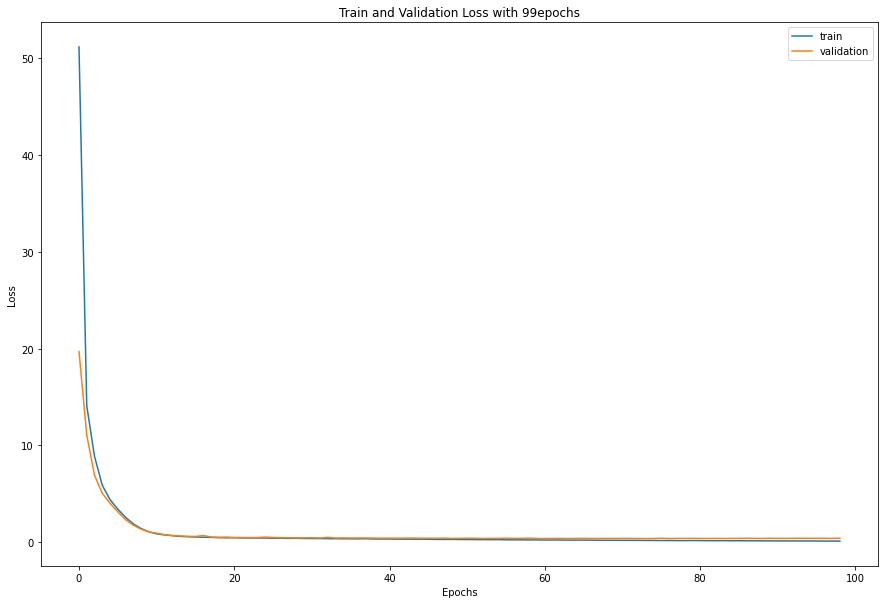

In [18]:
patience=25
plt.figure(figsize=(15,10))

# plot training and validation history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('Epochs')
plt.ylabel('Loss') 
plt.title('Train and Validation Loss with '+str(len(history.history['val_loss']))+'epochs')
plt.legend()
 
plt.savefig('train_validation_after_'+str(len(history.history['val_loss'])-patience)+"_epochs.png")

print('The optimal number of epochs is '+str(len(history.history['val_loss'])-patience))

In [19]:
predict1=np.zeros(os) 
predict1=predictions[-3]
    
predict2=np.zeros((os))
predict2=predictions[-2]
    
predict3=np.zeros((os))
predict3=predictions[-1]

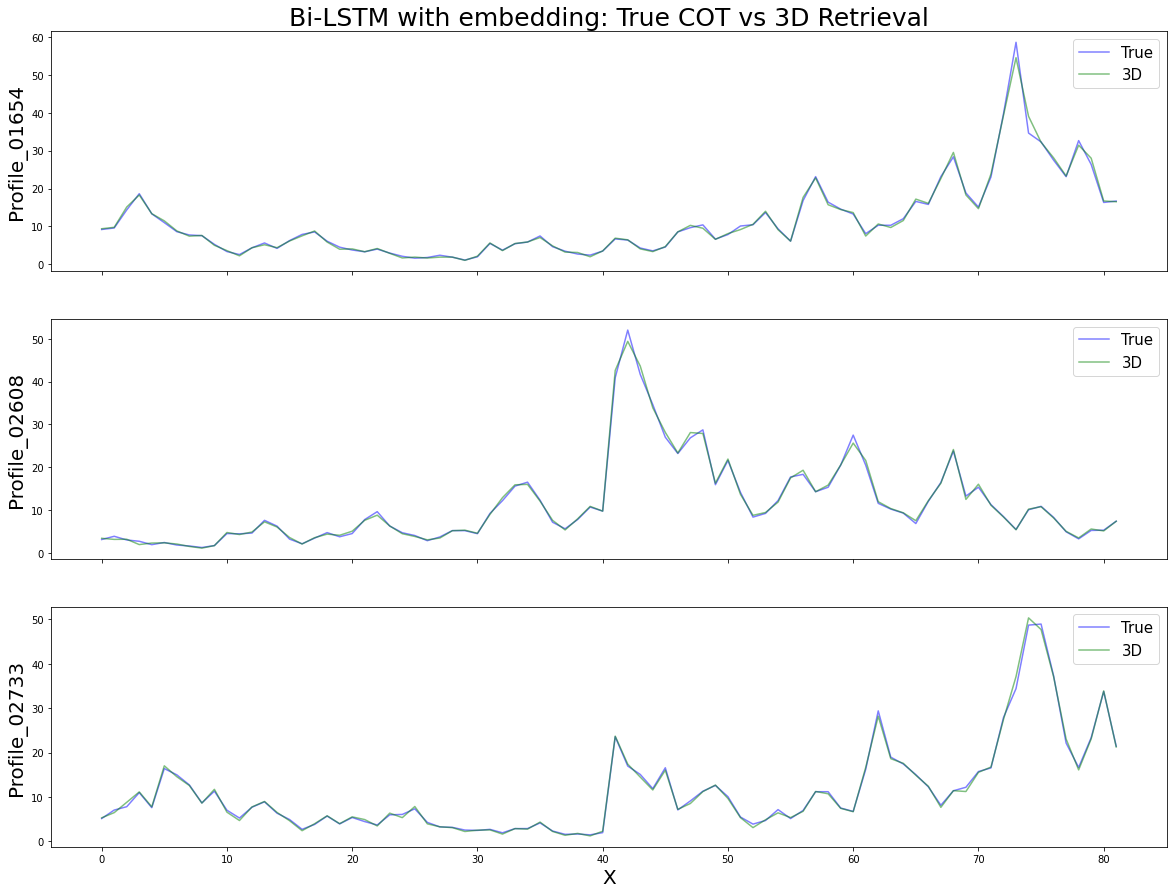

In [30]:
# plotting# ---------------------------------------------------------------------------------------------------
fgnm = "plots/5folds-predict_Bi-LSTM with embedding SZA=60 VZA=0 500m-64"+"_"+str(len(history.history['val_loss'])-patience)+'_epochs'
fig, axs = plt.subplots(nrows=3,ncols=1,sharex=True,figsize=(20,15))

# plots the last three test profiles

#plot the third last profile
ax = axs[0]
ax.set_title(r"Bi-LSTM with embedding: True COT vs 3D Retrieval",fontsize=25)
ax.plot(range(82),test_label[800-3],alpha=0.5,color="blue") #ground truth
ax.plot(range(82),predict1,alpha=0.5,color="green") 
ax.legend(["True", "3D"],fontsize=15)
ax.set_ylabel(r"Profile_01654",fontsize=20) 

#plot the second last profile
ax = axs[1]
ax.plot(range(82),test_label[800-2],alpha=0.5,color="blue")
ax.plot(range(82),predict2,alpha=0.5,color="green")
ax.legend(["True", "3D"],fontsize=15)
ax.set_ylabel(r"Profile_02608",fontsize=20)  

# plot the last profile
ax = axs[2]
ax.plot(range(82),test_label[800-1],alpha=0.5,color="blue")
ax.plot(range(82),predict3,alpha=0.5,color="green")
ax.legend(["True", "3D"],fontsize=15)
ax.set_ylabel(r"Profile_02733",fontsize=20)  
ax.set_xlabel('X',fontsize=20)

plt.savefig(fgnm+".png",dpi=300,bbox_inches='tight')

In [23]:
physics_retrieval1654=np.load('physics_retrieval1654.npy')
physics_retrieval2608=np.load('physics_retrieval2608.npy')
physics_retrieval2733=np.load('physics_retrieval2733.npy')


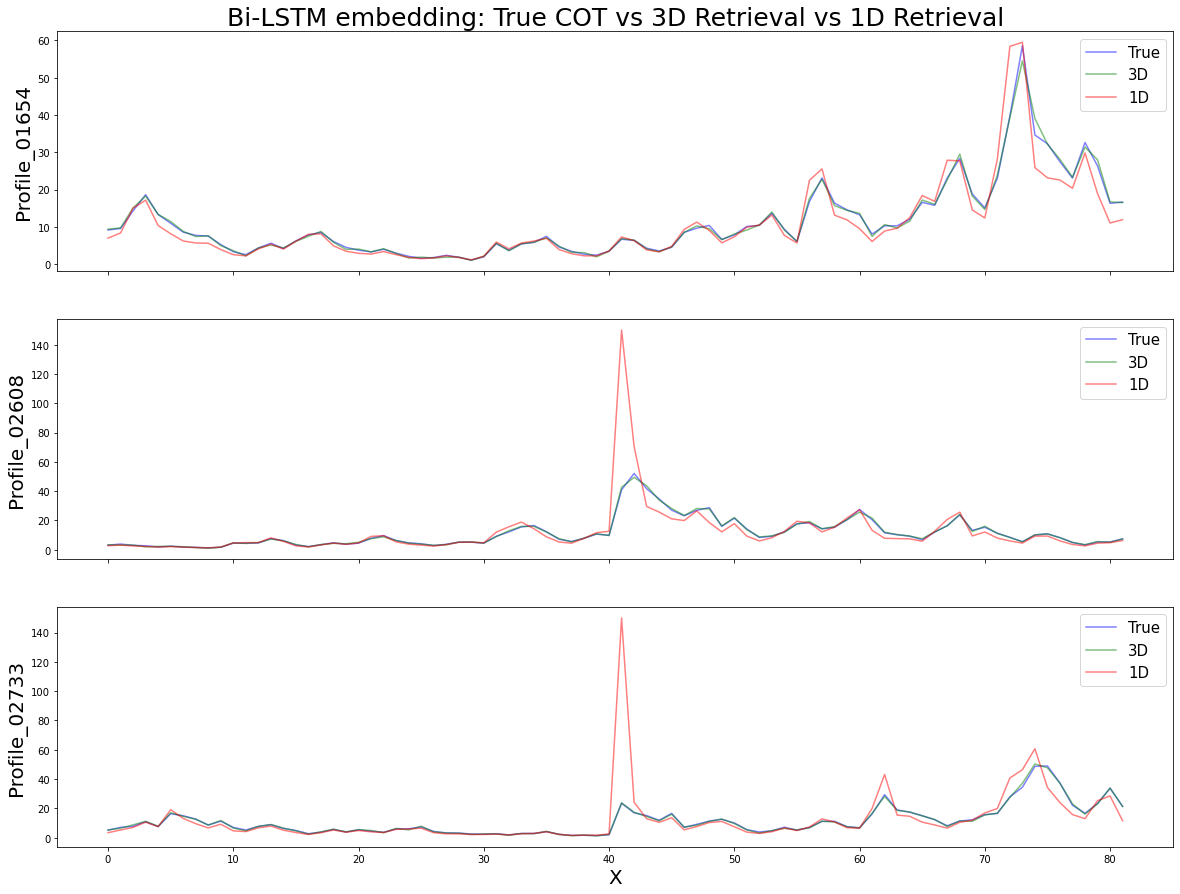

In [35]:
# plotting ---------------------------------------------------------------------------------------------------
fgnm = "plots/3_comparison_Bi-LSTM with embedding SZA=60 VZA=0 500m-64"
fig, axs = plt.subplots(nrows=3,ncols=1,sharex=True,figsize=(20,15))

# plots the last three test profiles

#plot the third last profile
ax = axs[0]
ax.set_title(r"Bi-LSTM embedding: True COT vs 3D Retrieval vs 1D Retrieval",fontsize=25)
ax.plot(range(82),test_label[800-3],alpha=0.5,color="blue") #ground truth
ax.plot(range(82),predict1,alpha=0.5,color="green") 
ax.plot(range(82),physics_retrieval1654,alpha=0.5,color="red") 

ax.legend(["True", "3D",'1D'],fontsize=15)
ax.set_ylabel(r"Profile_01654",fontsize=20) 

#plot the second last profile
ax = axs[1]
ax.plot(range(82),test_label[800-2],alpha=0.5,color="blue")
ax.plot(range(82),predict2,alpha=0.5,color="green")
ax.plot(range(82),physics_retrieval2608,alpha=0.5,color="red") 

ax.legend(["True", "3D",'1D'],fontsize=15)
ax.set_ylabel(r"Profile_02608",fontsize=20)  

# plot the last profile
ax = axs[2]
ax.plot(range(82),test_label[800-1],alpha=0.5,color="blue")
ax.plot(range(82),predict3,alpha=0.5,color="green")
ax.plot(range(82),physics_retrieval2733,alpha=0.5,color="red") 

ax.legend(["True", "3D",'1D'],fontsize=15)
ax.set_ylabel(r"Profile_02733",fontsize=20)  
ax.set_xlabel('X',fontsize=20)

plt.savefig(fgnm+".png",dpi=300,bbox_inches='tight')

# Plotting across predicted 82 COT values¶

In [21]:
std=[]
mean=[]

for k in range(os):
    tmp=[]
    for j in range(800):
        tmp.append(np.abs(predictions[j][k]-test_label[j][k]))
    std.append(np.std(tmp))
    mean.append(np.mean(tmp))

std=np.array(std)
mean=np.array(mean)

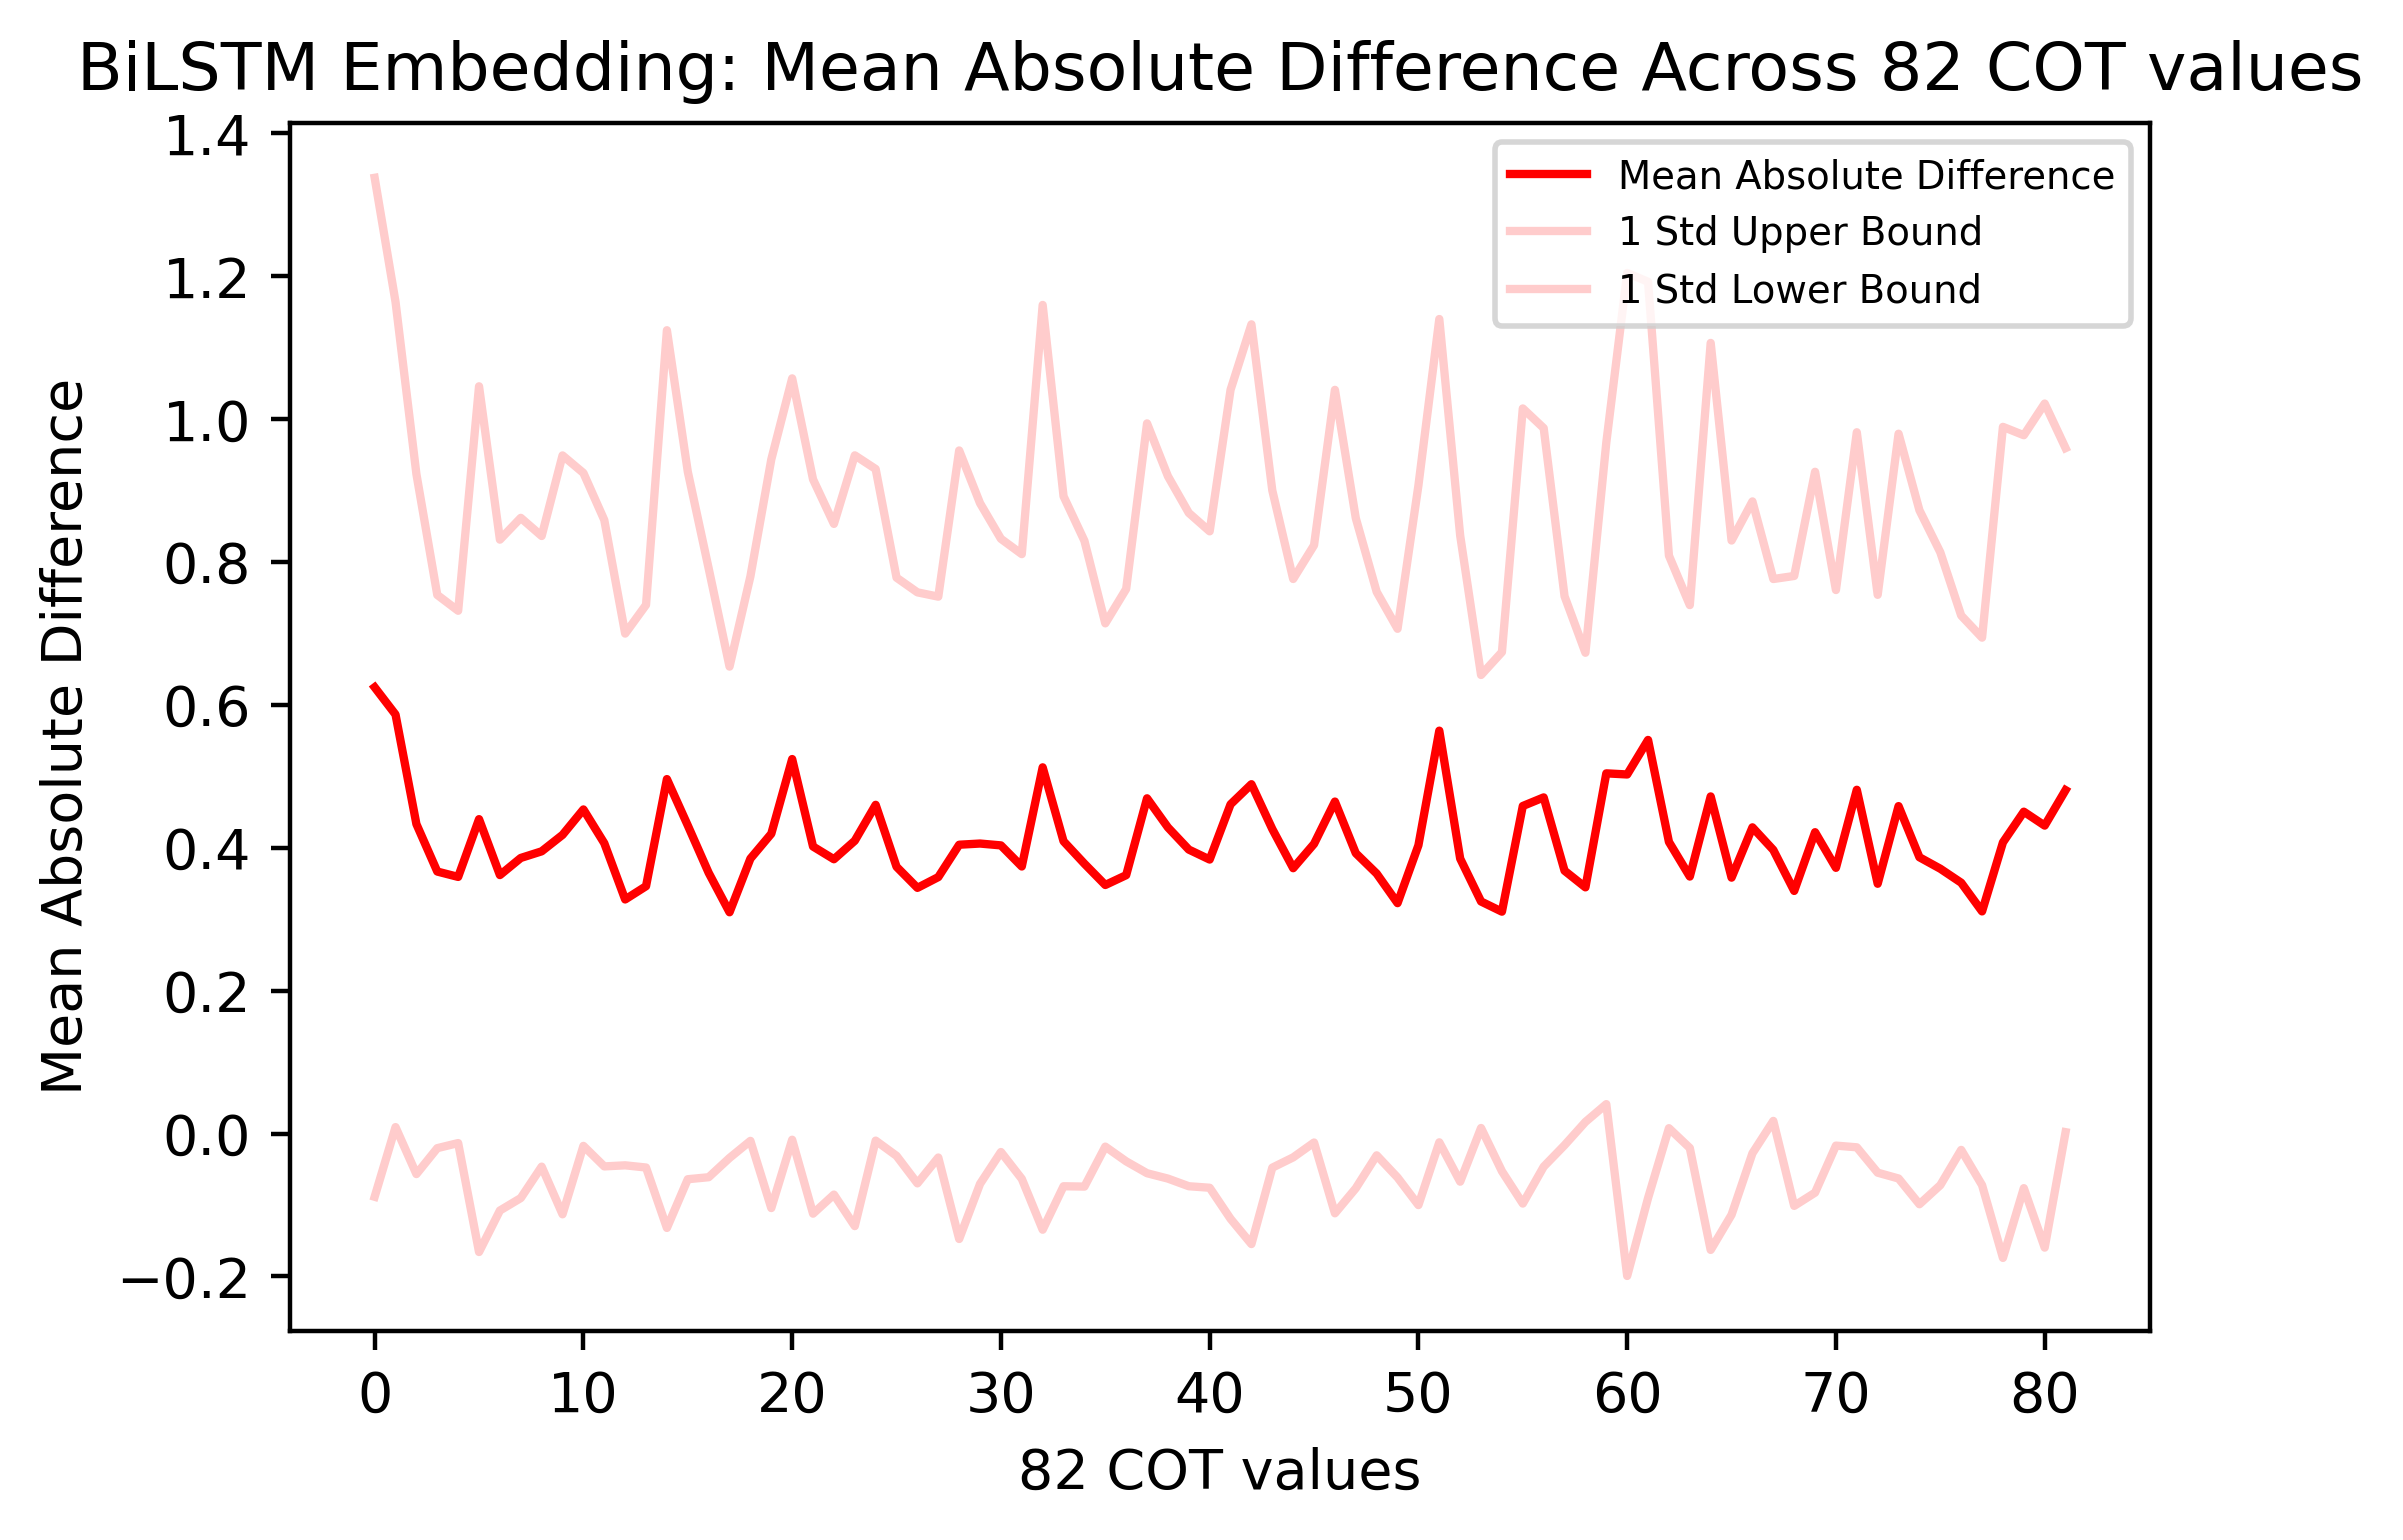

In [22]:
fig, ax = plt.subplots(dpi=400)
ax.plot(mean, '-r', label='Mean Absolute Difference')
ax.plot(mean+std, '-r', label='1 Std Upper Bound',alpha=0.2)
ax.plot(mean-std, '-r', label='1 Std Lower Bound',alpha=0.2)
ax.set_ylabel('Mean Absolute Difference ')  
ax.set_xlabel('82 COT values')

leg = ax.legend(loc=1,fontsize='x-small')
plt.title("BiLSTM Embedding: Mean Absolute Difference Across 82 COT values")

plt.savefig('plots/BiLSTM_with_Embedding_SZA=60_VZA=0_MeanAbsoluteDifferenceAcross82COTvalues.png',dpi=400)

# save model

In [22]:
# serialize model to JSON
model_json = model.to_json()
with open("bilstm_embedding_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("bilstm_embedding_model.h5")
print("Saved model to disk")

Saved model to disk


# load model

In [2]:
# load json and create model
from keras.models import model_from_json

json_file = open('bilstm_embedding_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("bilstm_embedding_model.h5")
print("Loaded model from disk")

Loaded model from disk


In [5]:
# evaluate loaded model on test data
ltype = 'mean_squared_error' #MSE
type2=tf.keras.metrics.RootMeanSquaredError() #RMSE
loaded_model.compile(optimizer='adam',loss=ltype,metrics=[ltype,type2])
results_rerun = loaded_model.evaluate(test_image, test_label, verbose=0)
predictions=loaded_model.predict(test_image)

In [6]:
print('test',loaded_model.metrics_names[1],results_rerun[1])
print('test',loaded_model.metrics_names[2],results_rerun[2])

test mean_squared_error 1.5850553512573242
test root_mean_squared_error 1.2484862804412842
